# Tech Challenge Predicao Plano de Saude
Serao utilizados modelos de regressao e classificacao para atuar de maneira preditiva a partir da base de dados.
A base de dados sera tratada e quando necessario serao aplicadas tecnicas como one hot enconding e label enconde.

## Verificacao de dados

In [1]:
# Realizacao de imports
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
# Leitura de dados e armazenamento em variavel
data = pd.read_csv('data/us-insurance-data.csv')

In [6]:
# Obtendo informacoes sobre os dados
data.shape

(1338, 7)

In [7]:
# Visualizando primeiras linhas do dataset
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
# Verificando existencia de valores nulos
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Preparacao de dados 

In [16]:
#Verificando valores para 'region'
set(data.region)

{'northeast', 'northwest', 'southeast', 'southwest'}

In [18]:
# Realizando label encode para 'sex' e 'smoker'
from sklearn.preprocessing import LabelEncoder

In [19]:
to_be_labeled_columns = ['sex', 'smoker']
label_encoder = LabelEncoder()
for column in to_be_labeled_columns:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [20]:
# Realizando one-hot-enconding para 'region'
dummy_region = pd.get_dummies(data.region, prefix='dummy')
encoded_data = pd.concat([data, dummy_region], axis=1)
encoded_data.drop('region', axis=1, inplace=True)
encoded_data.head()

,age,sex,bmi,children,smoker,charges,dummy_northeast,dummy_northwest,dummy_southeast,dummy_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


## Verificando correlacao

<Axes: >

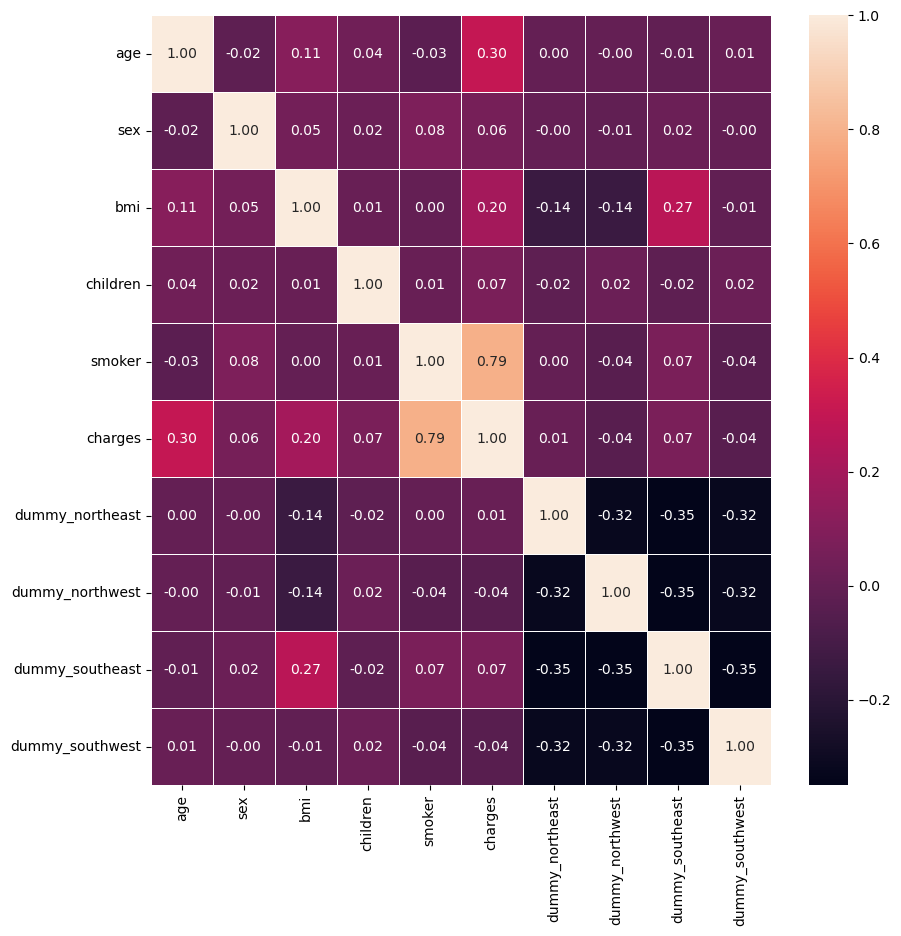

In [21]:
import matplotlib.pyplot as plt
import seaborn as sb
correlation_matrix = encoded_data.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 10))
sb.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2f')

## Elaboracao de modelo

In [22]:
# Definicao de features: selecionar variaveis com maior correlacao para evitar overfitting ou underfitting
x = encoded_data[["smoker", "age"]] # -> Feature
y = encoded_data["charges"] # -> Target

In [23]:
# Separacao de dados para testes e treinamento
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=22)
print("train base lenght: ", len(x_train))
print("test base lenght: ", len(x_test))

train base lenght:  1070
test base lenght:  268


## Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

predictions = model.predict(x_test)

## Decision Tree Regression

In [43]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth=10)
model_dtr.fit(x_train, y_train)
predictions_dtr = model_dtr.predict(x_test)

## Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
dtc_x = encoded_data.drop(columns=["charges"])
dtc_y = encoded_data["charges"]
dtc = DecisionTreeClassifier(random_state=22, criterion='gini', max_depth=2)
dtc.fit(x_train, y_train)
# dtc.predict(x_test)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

#### Nao faz sentido usar uma solucao de classificacao uma vez que nao estamos querendo prever uma saida com valor categorico, por exemplo: ser ou nao uma fraude/ ser ou nao um spam. Faz sentido usarmos uma solucao de regressao, uma vez que estamos tentando prever um valor continuo

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor
# Definindo o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=2, random_state=42)

# Treinando o modelo
rf_model.fit(x_train, y_train)

# Fazendo previsões no conjunto de teste
predictions_rf = rf_model.predict(x_test)


## Analise de resultados

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [41]:
import numpy as np
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [42]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r_square = r2_score(y_test, predictions)
mape_result = calculate_mape(y_test, predictions)

In [44]:
lin_mse = mean_squared_error(y_test, predictions_dtr)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y_test, predictions_dtr)
r2_dtr = r2_score(y_test, predictions_dtr)
mape_dtr = calculate_mape(y_test, predictions_dtr)

In [48]:
rf_mse = mean_squared_error(y_test, predictions_rf)
rf_mae = mean_absolute_error(y_test, predictions_rf)
mape_rf = calculate_mape(y_test, predictions_rf) 
r2_rf = r2_score(y_test, predictions_rf)

In [49]:
print(f'MSE LR: {mse}')
print(f'MAE LR: {mae}')
print(f'R² LR: {r_square}')
print(f"MAPE value LR: {mape_result:.2f}%")
print('------')
print(f'MSE DTR: {lin_mse}')
print(f'MAE DTR: {lin_mae}')
print(f'R² DTR: {r2_dtr}')
print(f"MAPE value DTR: {mape_dtr:.2f}%")
print('------')
print(f'MSE RF: {rf_mse}')
print(f'MAE RF: {rf_mae}')
print(f'R² RF: {r2_rf}')
print(f"MAPE value RF: {mape_rf:.2f}%")

MSE LR: 39646106.742787175
MAE LR: 3959.5652769390485
R² LR: 0.7305382027423435
MAPE value LR: 31.88%
------
MSE DTR: 43685755.51677634
MAE DTR: 3958.5814143263374
R² DTR: 0.7030820132609679
MAPE value DTR: 35.64%
------
MSE RF: 43748702.28894275
MAE RF: 4017.065571609995
R² RF: 0.7026541843578786
MAPE value RF: 40.49%
